In [865]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [866]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler 

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [867]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [868]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [869]:
train_delta_t = 0
max_depth = 8
eval_metric = 'rmse'
n_estimators = 100000
scaler_name = 'StandardScaler'
scaler_a = StandardScaler()
scaler_b = StandardScaler()
scaler_c = StandardScaler()
submission_path = 'clean_sub/'

In [870]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [871]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [872]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [873]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [874]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

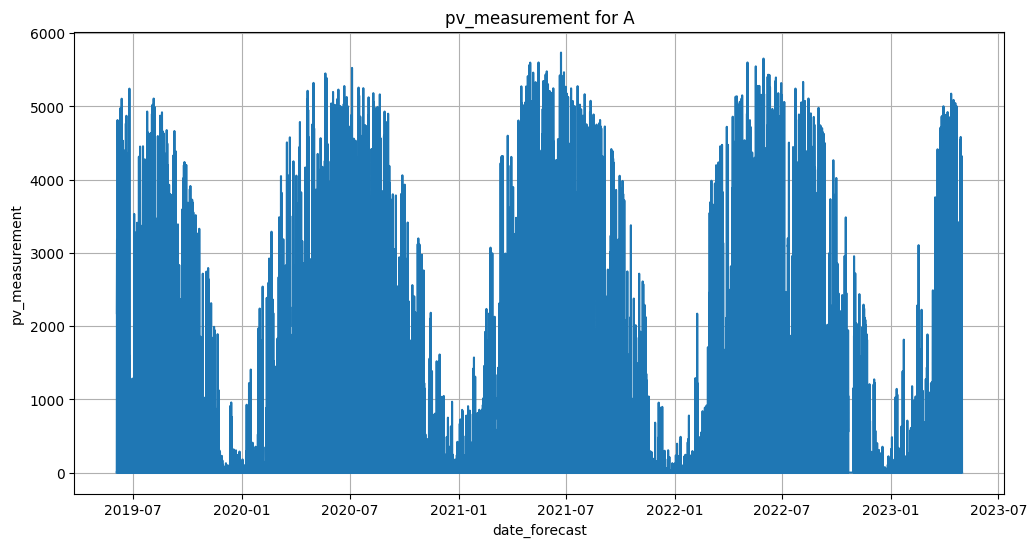

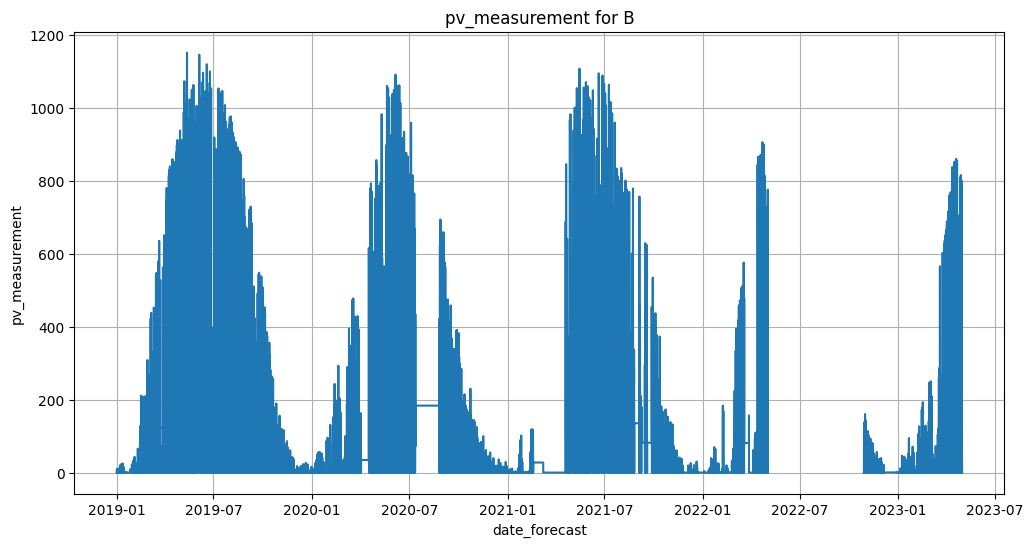

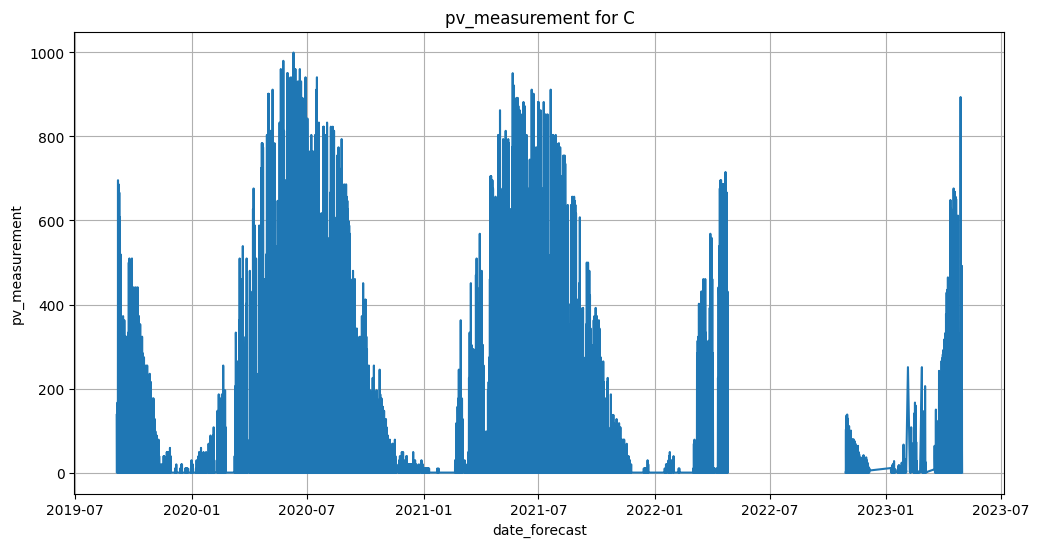

In [875]:
plt.figure(figsize=(12, 6)) 
plt.plot(train_a['time'], train_a['pv_measurement'])
plt.title('pv_measurement for A')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_b['time'], train_b['pv_measurement'])
plt.title('pv_measurement for B')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_c['time'], train_c['pv_measurement'])
plt.title('pv_measurement for C')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()   

# Réorganisation des df :

In [876]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

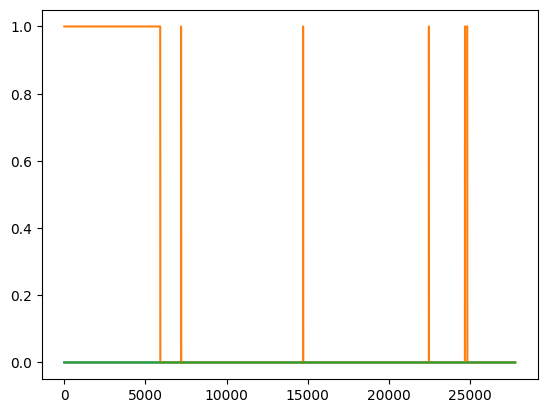

In [877]:
plt.plot(train_c.isna())

In [878]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [879]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

# Analyse des Nan

In [880]:
X_train_observed_a['snow_density:kgm3'].isna().sum()/len(X_train_observed_a)

0.9770453951748139

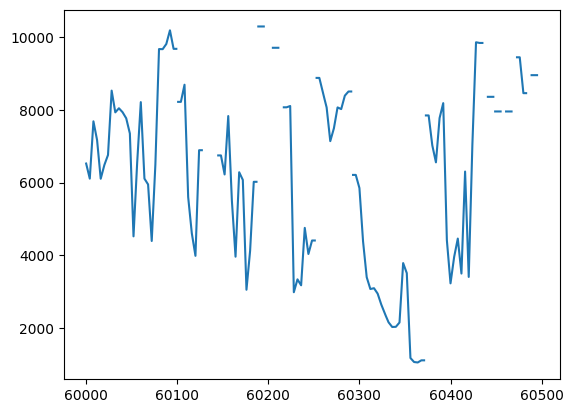

In [881]:
plt.plot(X_train_observed_a['ceiling_height_agl:m'][60000:60500])
#.plot(X_train_observed_a_nan['ceiling_height_agl:m'][60000:60500],ls="--")
#plt.plot(X_train_observed_a['cloud_base_agl:m'][60000:62000].isna())

**Conclusion** de l'analyse :    
- Il y a 3 variables avec des Nan
- Snow density est vide à 98% on la supprime
- les deux autres sont vide à 7 et 19% et ce sont des points manquant (problème dans la prise de mesure probablement)
- on décide donc de les compléter par prolongement (moyenne des points environnant)

In [882]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [883]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [884]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [885]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [886]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [887]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [888]:
# on coupe nos dataframe à une certaine date

# pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= split_date_a].copy()
# pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > split_date_a].copy()

# pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= split_date_b].copy()
# pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > split_date_b].copy()

# pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= split_date_c].copy()
# pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > split_date_c].copy()

mask_train_a = (X_total_a_y_nan['date_forecast'] <= split_date_a) | (X_total_a_y_nan['date_forecast'] > split_date2_a)

pv_train_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] <= split_date_a) | (X_total_a_y_nan['date_forecast'] > split_date2_a)].copy()
pv_test_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] > split_date_a) & (X_total_a_y_nan['date_forecast'] <= split_date2_a)].copy()

pv_train_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] <= split_date_b) | (X_total_b_y_nan['date_forecast'] > split_date2_b)].copy()
pv_test_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] > split_date_b) & (X_total_b_y_nan['date_forecast'] <= split_date2_b)].copy()

pv_train_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] <= split_date_c) | (X_total_c_y_nan['date_forecast'] > split_date2_c)].copy()
pv_test_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] > split_date_c) & (X_total_c_y_nan['date_forecast'] <= split_date2_c)].copy()


print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (31117, 47)
test_a : (2928, 47)
Rapport test/total : 8.6
train_b : (24311, 47)
test_b : (2852, 47)
Rapport test/total : 10.5
train_c : (18774, 47)
test_c : (2928, 47)
Rapport test/total : 13.5


## Changement type de la date_forecast

In [889]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [890]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [891]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Conversion du type de la date

In [892]:
# X_train_a[('date_forecast')] = X_train_a[('date_forecast')].values.astype("float64")
# X_train_b[('date_forecast')] = X_train_b[('date_forecast')].values.astype("float64")
# X_train_c[('date_forecast')] = X_train_c[('date_forecast')].values.astype("float64")
# X_test_a[('date_forecast')] = X_test_a[('date_forecast')].values.astype("float64")
# X_test_b[('date_forecast')] = X_test_b[('date_forecast')].values.astype("float64")
# X_test_c[('date_forecast')] = X_test_c[('date_forecast')].values.astype("float64")

## Normalisation

In [893]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.fit_transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [894]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [895]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [896]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [897]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:822.31651	validation_1-rmse:1526.92751
[1]	validation_0-rmse:642.02882	validation_1-rmse:1353.96182
[2]	validation_0-rmse:523.97189	validation_1-rmse:1238.02079
[3]	validation_0-rmse:445.85491	validation_1-rmse:1166.03274
[4]	validation_0-rmse:396.59195	validation_1-rmse:1126.49556


[5]	validation_0-rmse:360.61181	validation_1-rmse:1093.23499
[6]	validation_0-rmse:337.04017	validation_1-rmse:1076.80747
[7]	validation_0-rmse:321.63907	validation_1-rmse:1071.23082
[8]	validation_0-rmse:306.50827	validation_1-rmse:1077.62693
[9]	validation_0-rmse:294.38964	validation_1-rmse:1070.14239
[10]	validation_0-rmse:287.42092	validation_1-rmse:1064.55369
[11]	validation_0-rmse:281.29467	validation_1-rmse:1062.17695
[12]	validation_0-rmse:272.84034	validation_1-rmse:1061.12522
[13]	validation_0-rmse:268.59452	validation_1-rmse:1063.62491
[14]	validation_0-rmse:260.38572	validation_1-rmse:1064.06596
[15]	validation_0-rmse:253.13196	validation_1-rmse:1059.33466
[16]	validation_0-rmse:249.35451	validation_1-rmse:1056.77471
[17]	validation_0-rmse:247.22576	validation_1-rmse:1057.28538
[18]	validation_0-rmse:245.10440	validation_1-rmse:1056.86818
[19]	validation_0-rmse:241.06882	validation_1-rmse:1061.01598
[20]	validation_0-rmse:237.29445	validation_1-rmse:1061.62969
[21]	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:225.96303	validation_1-rmse:1061.08990
[24]	validation_0-rmse:221.19209	validation_1-rmse:1059.49762
[25]	validation_0-rmse:218.31374	validation_1-rmse:1059.11930
[26]	validation_0-rmse:215.63175	validation_1-rmse:1059.49473
[27]	validation_0-rmse:214.29712	validation_1-rmse:1059.53286
[28]	validation_0-rmse:212.63396	validation_1-rmse:1060.98884
[29]	validation_0-rmse:208.78403	validation_1-rmse:1058.37837
[30]	validation_0-rmse:205.77463	validation_1-rmse:1059.30766
[31]	validation_0-rmse:203.28843	validation_1-rmse:1059.84514
[32]	validation_0-rmse:201.26788	validation_1-rmse:1059.21512
[33]	validation_0-rmse:197.62418	validation_1-rmse:1054.08246
[34]	validation_0-rmse:195.50780	validation_1-rmse:1053.21430
[35]	validation_0-rmse:194.19700	validation_1-rmse:1053.44892
[36]	validation_0-rmse:192.76621	validation_1-rmse:1053.95816
[37]	validation_0-rmse:190.77620	validation_1-rmse:1053.66123
[38]	validation_0-rmse:186.72476	validation_1-rmse:1053.19887
[39]	val

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:22.59169	validation_1-rmse:265.82091
[30]	validation_0-rmse:22.23444	validation_1-rmse:267.84891
[31]	validation_0-rmse:21.63622	validation_1-rmse:267.78164
[32]	validation_0-rmse:21.42473	validation_1-rmse:267.66189
[33]	validation_0-rmse:21.15538	validation_1-rmse:267.67874
[34]	validation_0-rmse:20.85322	validation_1-rmse:267.60689
[35]	validation_0-rmse:20.62001	validation_1-rmse:267.57286
[36]	validation_0-rmse:19.96340	validation_1-rmse:267.44964
[37]	validation_0-rmse:19.68645	validation_1-rmse:267.42259
[38]	validation_0-rmse:19.32123	validation_1-rmse:267.49173
[39]	validation_0-rmse:18.98657	validation_1-rmse:267.27140
[40]	validation_0-rmse:18.67419	validation_1-rmse:267.30734
[41]	validation_0-rmse:18.29293	validation_1-rmse:267.26300
[42]	validation_0-rmse:17.96455	validation_1-rmse:267.29680
[43]	validation_0-rmse:17.68574	validation_1-rmse:267.31037
[44]	validation_0-rmse:17.38001	validation_1-rmse:267.28375
[45]	validation_0-rmse:17.02246	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-rmse:16.34026	validation_1-rmse:202.74663
[37]	validation_0-rmse:16.28036	validation_1-rmse:202.74882
[38]	validation_0-rmse:16.00315	validation_1-rmse:202.78523
[39]	validation_0-rmse:15.59801	validation_1-rmse:202.74987
[40]	validation_0-rmse:15.10738	validation_1-rmse:202.69110
[41]	validation_0-rmse:14.89912	validation_1-rmse:202.76912
[42]	validation_0-rmse:14.72505	validation_1-rmse:202.76544
[43]	validation_0-rmse:14.39598	validation_1-rmse:202.98101
[44]	validation_0-rmse:14.11102	validation_1-rmse:203.01105
[45]	validation_0-rmse:14.02836	validation_1-rmse:203.01290
[46]	validation_0-rmse:13.69792	validation_1-rmse:203.03604
[47]	validation_0-rmse:13.56959	validation_1-rmse:203.06486
[48]	validation_0-rmse:13.28093	validation_1-rmse:203.09405
[49]	validation_0-rmse:13.15248	validation_1-rmse:203.15623
[50]	validation_0-rmse:12.97358	validation_1-rmse:202.95134
[51]	validation_0-rmse:12.74693	validation_1-rmse:202.74670
[52]	validation_0-rmse:12.36275	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

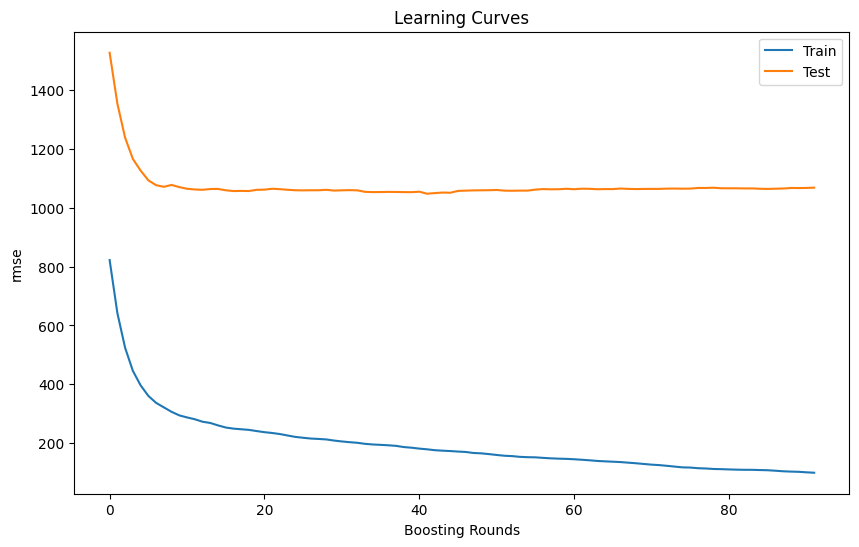

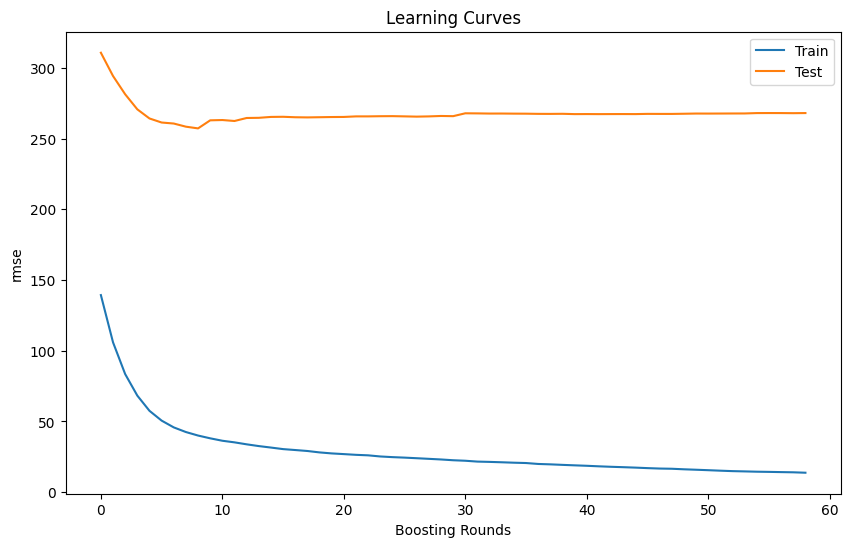

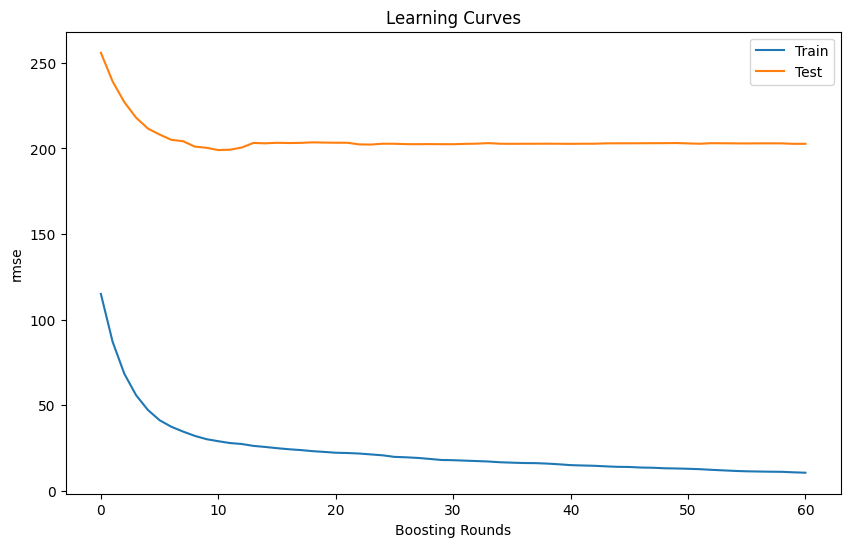

In [898]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

In [899]:
min_error_a, min_error_b, min_error_c

(1047.7730945762205, 257.17618893536826, 199.04857826007927)

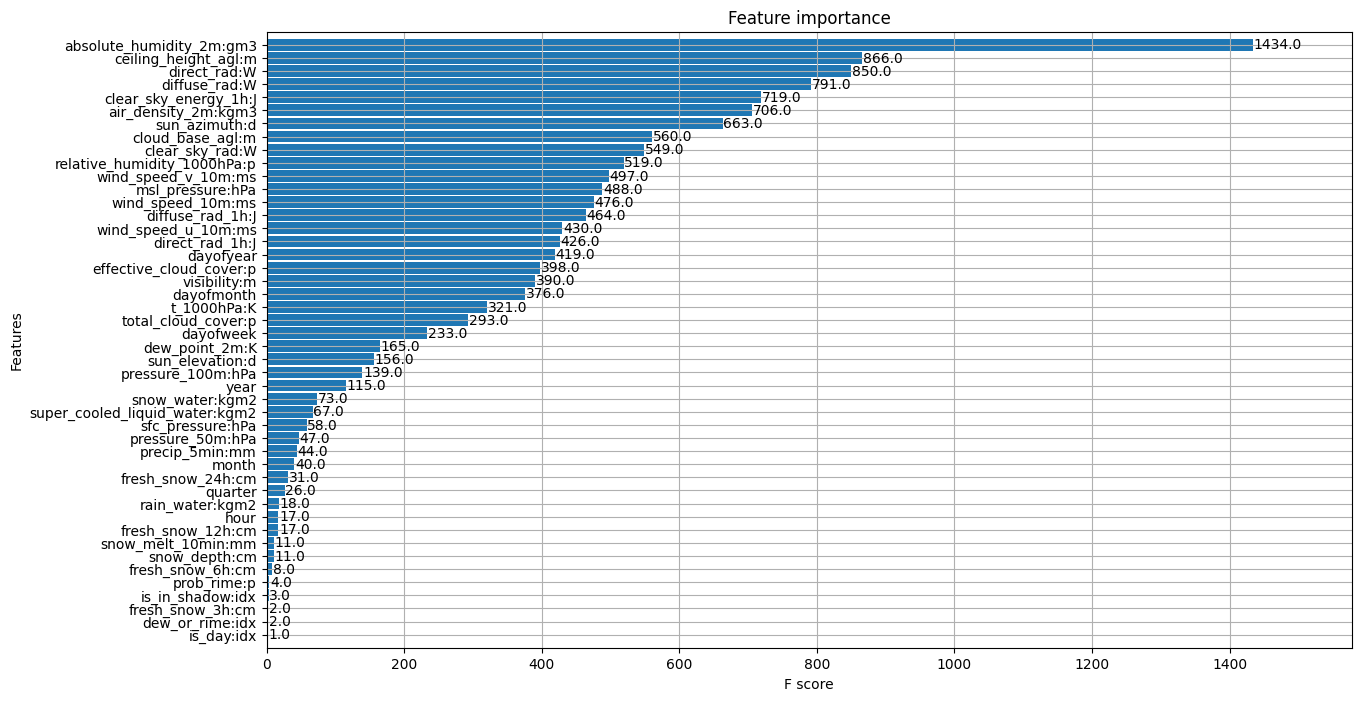

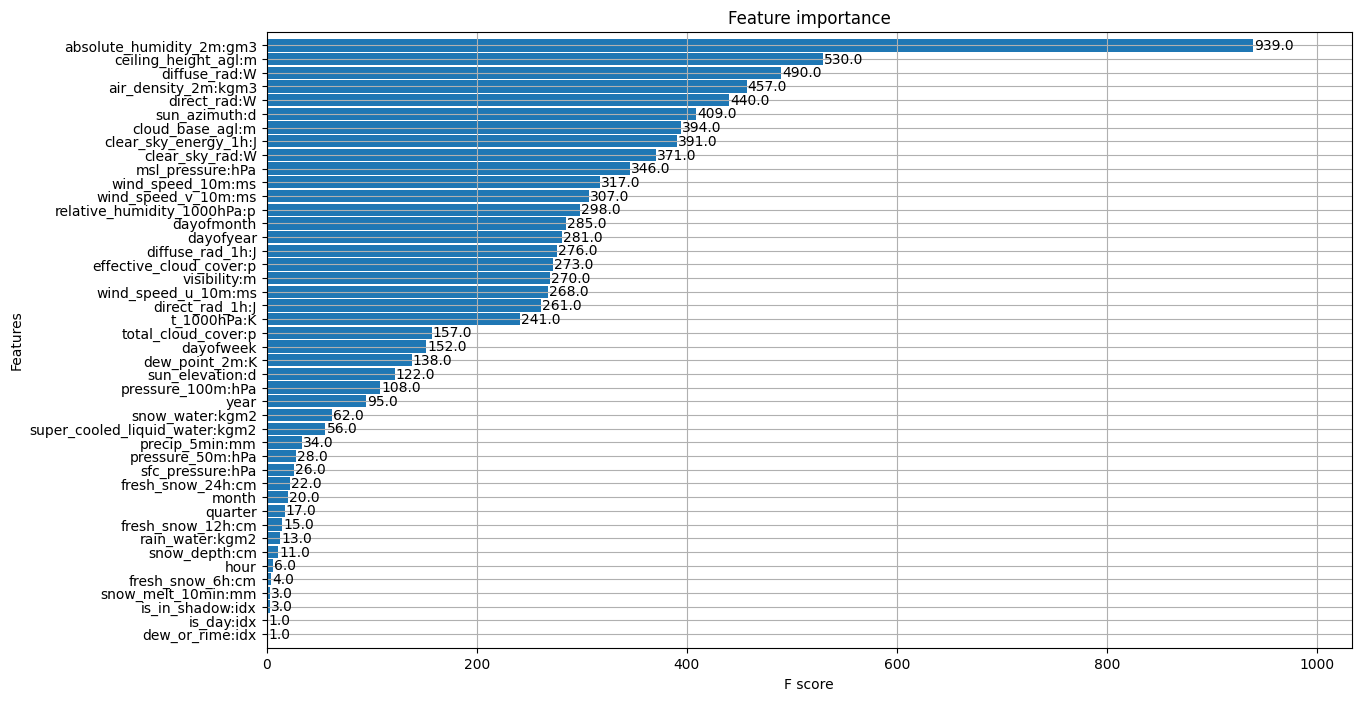

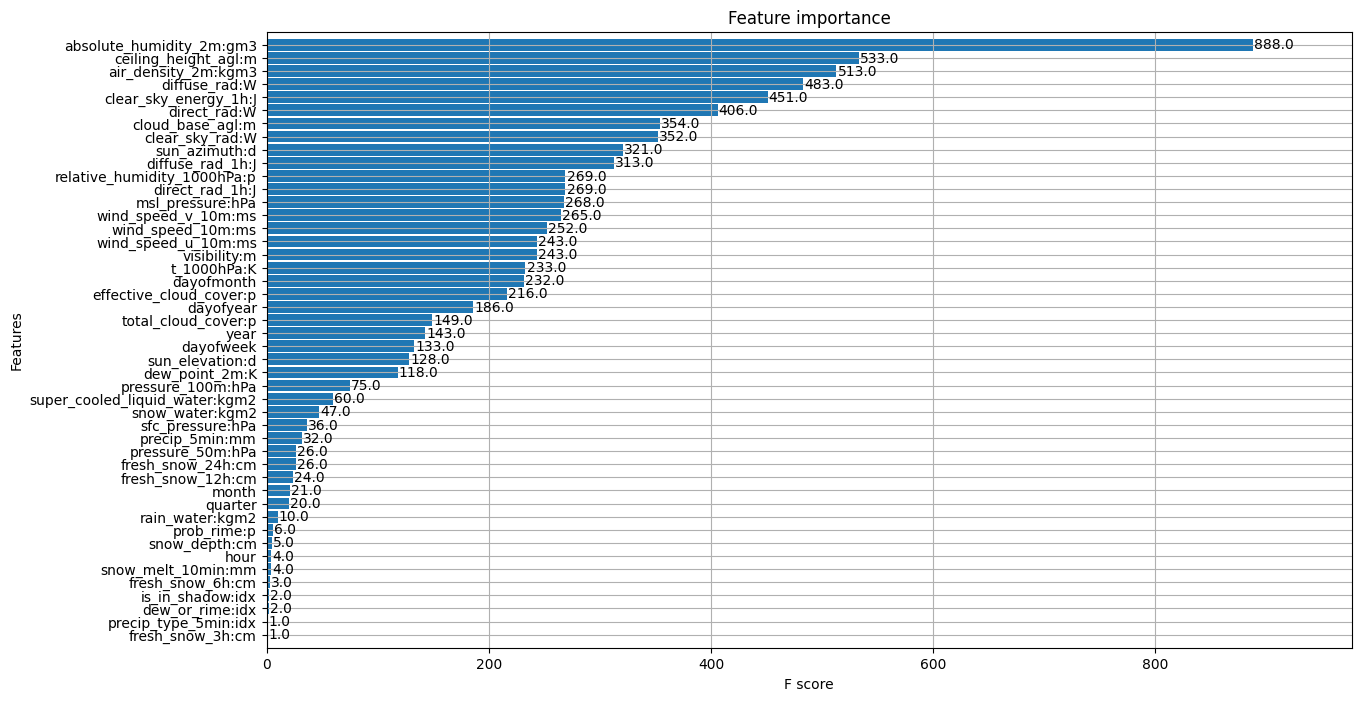

In [900]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [901]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [902]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_47130/182118369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_47130/182118369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_47130/182118369.py:

In [903]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

mae = (mae_a + mae_b + mae_c) / 3
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 636.5465365603314 MAE b: 163.32599124508855 MAE c: 166.42770626250672
MAE on test set: 322.1000780226422


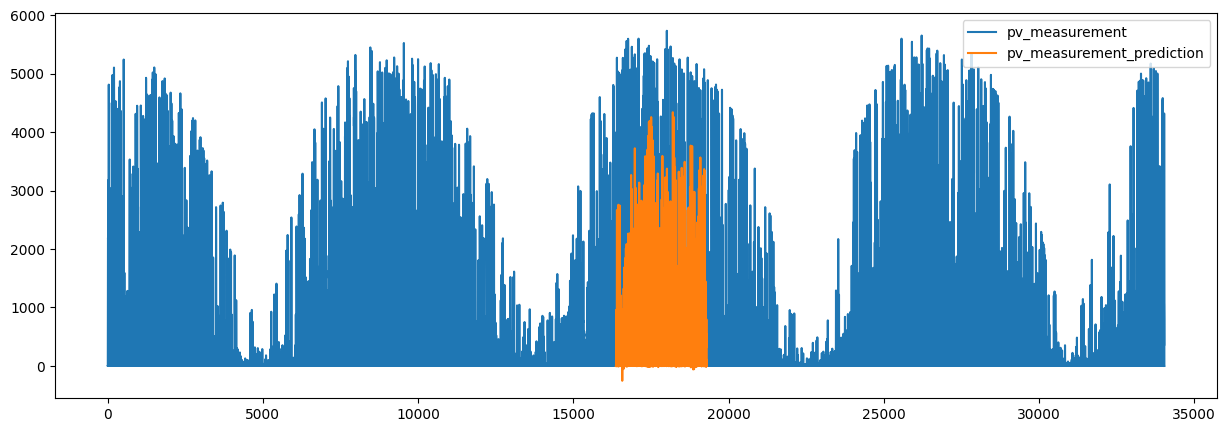

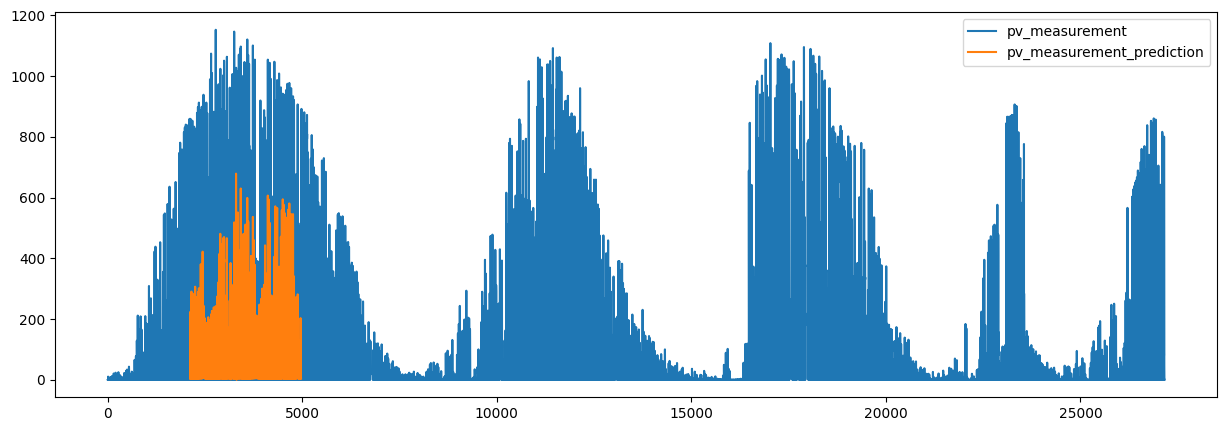

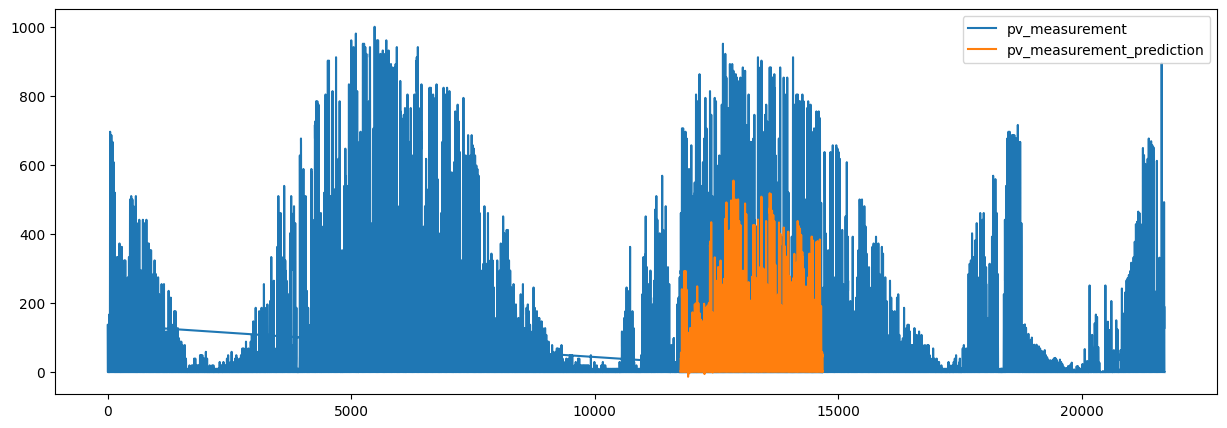

In [904]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))

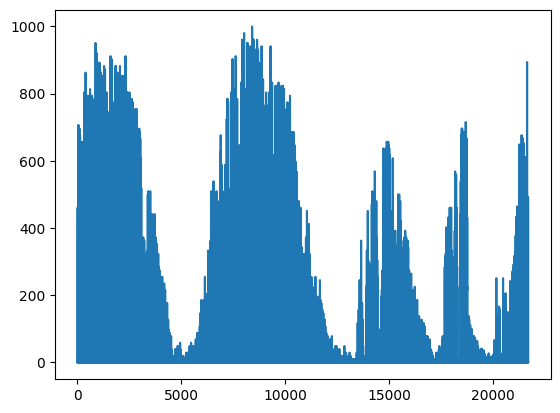

In [905]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [906]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [907]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [908]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [909]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [910]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

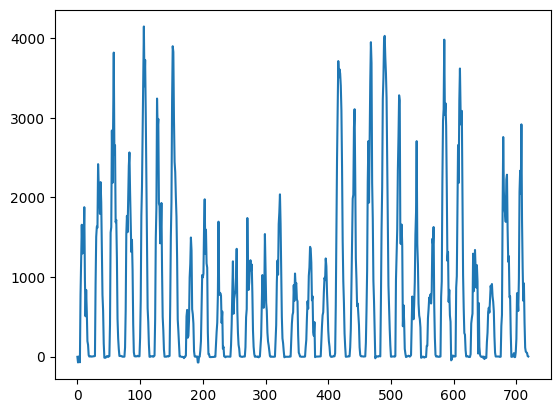

In [911]:
plt.plot(result_A)

In [912]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [913]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [914]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

3.818303964828373

In [915]:
negative_mask = result < 10
result[negative_mask] = 0

In [916]:
nom_fichier = f'XGBoost_separated_loc_n_estimators_{n_estimators}_delta_{delta_title}_min_{scaler_name}_max_depth_{max_depth}_mae_{int(mae)}_{eval_metric}_{int(min_error_a)}_{int(min_error_b)}_{int(min_error_c)}'
repertoire = submission_path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [917]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [918]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0

**Liste amélioration V2** :

- Gestion zones continues B et C (suppression)
-